In [2]:
import numpy as np
import window
from IPython.display import clear_output
from time import sleep

SIZE = 500
TIMESTEPS = 32

def to_window(x, y):
    return x * SIZE/2 + SIZE/2, y * SIZE/2 + SIZE/2

def uv(v):
    return v / np.linalg.norm(v)

class Rect(object):
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.hit = False
        
    def point_inside(self, px, py):
        return abs(px - self.x) < self.w/2 and abs(py - self.y) < self.h/2
    
    def collide(self, puck):
        if self.point_inside(puck.x, puck.y):
            if puck.x < self.x:
                puck.x -= .2
                puck.xv = 0.0
            elif puck.x > self.x:
                puck.x += .2
                puck.xv = 0.0
            return True
        return False
        
    def draw(self, window, col=(1, 1, 1)):
        coords = to_window(self.x, self.y)
        ww, hh = self.w * SIZE/2, self.h * SIZE/2
        window.draw_rect(coords[0] - ww/2, \
                         coords[1] - hh/2, ww, hh, (1, 1, 1) if self.hit else col, thickness=0)

class Puck(object):
    def __init__(self):
        self.x, self.y = 0.0, 0.0
        self.xv, self.yv = 0.0, 0.0
        
        self.init_network()
        
    def init_network(self):
        # network
        in_dim = self.features().shape[1]
        hdim = 64
        
        self.act = lambda x: np.tanh(x)
        self.act_p = lambda x: 1 - np.tanh(x)**2
        
        #self.act = lambda x: x * (x > 0)
        #self.act_p = lambda x: (x > 0).astype(np.float32)
        
        self.W1 = np.random.randn(in_dim, hdim) * .1
        self.W2 = np.random.randn(hdim, 2) * .1
        
        # replay
        self.memory = []
        
    def features(self, x=None, y=None):
        xx = x if x else self.x
        yy = y if y else self.y
        
        # whacky features
        #return np.array([[xx, yy, xx**2, yy**2, xx*yy, np.cos(xx), np.cos(yy)]])
        
        # grid features
        #nb_fet = 20 # buckets
        #z = np.zeros([nb_fet, nb_fet])
        #xi = int(np.floor((xx+1.0)/2.0 * (nb_fet-1)))
        #yi = int(np.floor((yy+1.0)/2.0 * (nb_fet-1)))
        #z[xi, yi] = 1.0
        #return z.reshape(1, nb_fet*nb_fet)
    
        # raw features
        return np.array([[xx, yy]])
        
    def ff(self, features):
        
        #features = np.concatenate((features, np.ones([1, 1])), axis=1)
        
        z1 = features.dot(self.W1)
        h1 = self.act(z1)
        #h1 = np.concatenate((h1, np.ones([1, 1])), axis=1)
        
        z2 = h1.dot(self.W2)
        h2 = self.act(z2)
        #h2 = z2
        
        return (features, z1, h1, z2, h2)
    
    def fit(self, state, action, rtrace):
        #clear_output(wait=True)
        #print('fitting {} to {}'.format(state, action))
        features, z1, h1, z2, h2 = self.ff(state)
        
        dh2 = (h2 - action)
        dz2 = np.multiply(dh2, self.act_p(z2))
        #dz2 = dh2
        
        g2 = np.multiply(h1.T, dz2)
        
        dh1 = self.W2.dot(dz2.T).T #[:, :-1]
        dz1 = np.multiply(dh1, self.act_p(z1))
        
        g1 = np.multiply(features.T, dz1)
                
        self.W2 -= g2 * 0.0005 * rtrace
        self.W1 -= g1 * 0.0005 * rtrace
        
    def train(self, iters=10):
        # sample an episode of experience
        # see if it got a reward, and push all state action pairs to be more likely if so
        for i in range(iters):
            ep = self.memory[np.random.randint(0, len(self.memory))]
            self.train_ep(ep)
        
    def train_ep(self, ep):
        rtrace = np.linspace(0.0, ep[-1]['r'], len(ep))
        #rtrace = np.exp(rtrace*10)
        #rtrace = (rtrace-1)/np.max(rtrace-1)
        #rtrace = np.ones([len(ep)]) * ep[-1]['r']
        #rtrace[:int(len(rtrace)/2)] = 0.0
        indices = np.arange(0, len(ep))
        np.random.shuffle(indices)
        for i in indices:
            xp = ep[i]
            self.fit(xp['s0'], xp['a0'], rtrace[i])
        
    def sample_action(self, features, stddev=1, exploration=0.0):
        x, z1, h1, z2, h2 = self.ff(features)
        
        # means are h2_1 and h2_2
        # sample with stddev
        a = h2 * (1.0 - exploration) + np.random.randn(1, 2) * stddev * exploration
        
        return a
    
    def move(self, a):
        self.x += a[0, 0]
        self.y += a[0, 1]
        #self.x = self.xv
        #self.y = self.yv
        #self.xv *= 0.0
        #self.yv *= 0.0
        self.x = np.clip(self.x, -1.0, 1.0)
        self.y = np.clip(self.y, -1.0, 1.0)
        
    def draw(self, window):
        coords = to_window(self.x, self.y)
        window.draw_rect(coords[0]-4, coords[1]-4, 8, 8, (1, 1, 1), thickness=0)
        
    def draw_episode(self, window, ep):
        verts = []
        for xp in ep:
            verts += [xp['s1xy']]
        verts = np.array(verts)
        verts *= SIZE/2
        verts += [SIZE/2, SIZE/2]
        window.draw_poly(vertices=verts, color=(1, 1, 1), loop=False)

def draw_field():
    # draw policy as a grid of arrows
    nb_vec = 10
    for xx in np.linspace(-1, 1, nb_vec):
        for yy in np.linspace(-1, 1, nb_vec):
            features = puck.features(xx, yy)
            a = puck.sample_action(features, stddev=0.0, exploration=0.0)
            #a *= 10.0
            a = uv(a) * 20.0

            start_p = to_window(xx, yy)
            end_p = (start_p[0] + a[0, 0], start_p[1] + a[0, 1])
            w.draw_line(start_p, end_p, (0, 0, 1), (1, 1, 1))
            
def draw_all():
    reward.draw(w, (0, 1, 0))
    punish.draw(w, (1, 1, 0))

    puck.draw(w)

    #w.draw_matrices([puck.W1, puck.W2], x=10, y=SIZE - 10)

    draw_field()

    w.draw_text('episode: {} memories: {} explore: {}'.format(\
                ep, len(puck.memory), np.round(exploration, 2)), size=12, p=(10, 10))

        
w = window.Window(caption='Puck', width=SIZE, height=SIZE)
puck = Puck()

# reward square
reward = Rect(0, 0, .8, .3)
punish = Rect(0, 0, .6, .6)

stddev = .1
exploration = 1.0
ep = 0

last_mouse = [0.0, 0.0]
mouse_fits = []

speedup = False
running = True
reset = False
while running:
    
    if len(puck.memory) > 5:
        puck.train(min(10, len(puck.memory)))
    
    puck.x = np.random.random_sample() * 2.0 - 1.0
    puck.y = np.random.random_sample() * 2.0 - 1.0
    
    s0xy = (puck.x, puck.y)
    s0 = puck.features()
    a0 = puck.sample_action(s0, stddev, exploration)
    
    episode = []
    
    ep += 1
    t = 0
    
    reset = False
    while not reset:

        if w.pressed(window.key.R):
            puck.init_network()
            mouse_fits = []
            reset = True
            
        if w.pressed(window.key.S):
            speedup = not speedup
            
        if w.pressed(window.key.UP):
            exploration += .05
        if w.pressed(window.key.DOWN):
            exploration -= .05
        exploration = np.clip(exploration, 0, 1)

        w.reset_keys()
        
        # act
        puck.move(a0)
        
        # reward
        r = 0.0
        
        punish.hit = False
        reward.hit = False
        if punish.point_inside(puck.x, puck.y):
            punish.hit = True
            r = 0.0
            reset = True
        elif reward.point_inside(puck.x, puck.y):
            reward.hit = True
            r = 1.0
            reset = True
        
            
        s1xy = (puck.x, puck.y)
        s1 = puck.features()
        a1 = puck.sample_action(s1, stddev, exploration)
        
        episode += [{'s0': s0.copy(), 'a0': a0, 'r': r, 's1': s1.copy(), 'a1': a1, 's0xy': s0xy, 's1xy': s1xy}]
        
        s0xy = s1xy
        s0 = s1.copy()
        a0 = a1
        
        t += 1
        
        if t > TIMESTEPS:
            reset = True
            
        remember = reset and episode[-1]['r'] != 0
        
        if remember:
            puck.memory += [episode]
            
        w.clear()
        
        if reset:
            puck.draw_episode(w, episode)
            draw_all()
            running = w.update()
        
        if not speedup:
            draw_all()
            running = w.update()
    
print('done')

done


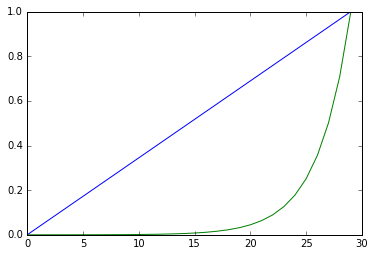

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
x = np.linspace(0, 1, 30)
xexp = np.exp(x*10)
xexp = (xexp-1)/np.max(xexp-1)
plt.plot(range(30), x, range(30), xexp)